In [1]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import weighted_mode
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler

import random

from timeit import default_timer as timer 
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import resample

import pandas as pd

In [2]:
import pathlib
#PROJECT_PATH = pathlib.Path(__file__).parent.parent.resolve()
DEVELOPMENT_FILE = "../Files/metadata/development.csv"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [5]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [6]:
# Assuming dataset.data() returns your numpy array and classes.label_to_class converts labels to classes
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

# Take only the melspect feature
X_new = X[:, 12:76, :]

In [7]:
# Load the data into a DataFrame (replace this with your data loading code)
data = pd.read_csv(DEVELOPMENT_FILE)

# Get unique speaker IDs
speaker_ids = data['speaker_id'].unique()

# Split speaker IDs into train, test, and dev sets
train_speaker_ids, test_dev_speaker_ids = train_test_split(speaker_ids, test_size=0.2, random_state=42)
test_speaker_ids, dev_speaker_ids = train_test_split(test_dev_speaker_ids, test_size=0.5, random_state=42)

# Filter data into train, test, and dev sets based on speaker IDs
train_data = data[data['speaker_id'].isin(train_speaker_ids)]
test_data = data[data['speaker_id'].isin(test_speaker_ids)]
dev_data = data[data['speaker_id'].isin(dev_speaker_ids)]

# Optionally, shuffle the train, test, and dev DataFrames
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
dev_data = dev_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Oversample specific words in the training data
words_to_oversample = ['Alarm', 'aus', 'offen']  # List of words to oversample
oversampled_data = pd.concat([resample(train_data[train_data['word'].isin(words_to_oversample)], 
                                       replace=True,  # With replacement
                                       n_samples=3000,  # Adjust oversampling size as needed
                                       random_state=42),  # Set random state for reproducibility
                              train_data])

# Shuffle the oversampled data
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Get the indices of rows corresponding to speaker IDs in train, test, and dev sets
# train_indices = train_data['id'].values
# Get the indices of rows corresponding to speaker IDs in train, test, and dev sets
train_indices = oversampled_data['id'].values
test_indices = test_data['id'].values
dev_indices = dev_data['id'].values

# Select the corresponding columns of X for train, test, and dev sets
X_train = X_new[train_indices, :, :]
X_test = X_new[test_indices, :, :]
X_dev = X_new[dev_indices, :, :]

# Split labels (y) along with features (X)
y_train = y[train_indices]
y_test = y[test_indices]
y_dev = y[dev_indices]

In [10]:
# Check if oversampling worked as expected
print(oversampled_data['word'].value_counts())

other          3520
offen          2651
Alarm          2608
aus            2603
Schraube       1627
Fernseher      1626
Lüftung        1626
Leitung        1626
nicht          1625
Ofen           1624
wunderbar      1624
Licht          1624
Radio          1622
Haus           1622
an             1621
kann           1620
Brötchen       1620
Spiegel        1620
warm           1620
Staubsauger    1619
Heizung        1618
Name: word, dtype: int64


In [11]:
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_dev.shape)

Train set shape: (38966, 64, 44)
Test set shape: (4571, 64, 44)
Validation set shape: (4759, 64, 44)


In [12]:
# Assuming X_train, X_test, y_train, y_test are numpy arrays
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # y_train contains integer labels
y_test_tensor = torch.tensor(y_test, dtype=torch.long)    # y_test contains integer labels
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)    # y_dev contains integer labels

X_train_tensor = X_train_tensor.unsqueeze(dim=1)
X_test_tensor = X_test_tensor.unsqueeze(dim=1)
X_dev_tensor = X_dev_tensor.unsqueeze(dim=1)

# Create training and test datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

In [13]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    drop_last=True,
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

dev_dataloader = DataLoader(dev_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of dev dataloader: {len(dev_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1217 batches of 32
Length of test dataloader: 142 batches of 32
Length of dev dataloader: 148 batches of 32


In [14]:
class AudioClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioClassifierCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        
        # Reshape the tensor to have a two-dimensional shape
        x = x.view(-1, 128 * 4 * 2)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [15]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()  # Set the model to training mode
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()  # Accumulate the loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))  # Accumulate the accuracy

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader, model, loss_fn, accuracy_fn, device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradient computation
        for batch, (X, y) in enumerate(data_loader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()  # Accumulate the loss
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))  # Accumulate the accuracy

        # Calculate loss and accuracy per epoch and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [16]:
# Initialize the model
model = AudioClassifierCNN(len(classes.CLASSES))

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
torch.manual_seed(42)

# Measure time
train_time_start_model = timer()

# Train and test model 
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.65949 | Train accuracy: 79.41%
Test loss: 0.53106 | Test accuracy: 87.61%

Epoch: 1
---------
Train loss: 0.25511 | Train accuracy: 91.65%
Test loss: 0.58783 | Test accuracy: 86.25%

Epoch: 2
---------
Train loss: 0.19071 | Train accuracy: 93.92%
Test loss: 0.32596 | Test accuracy: 90.16%

Epoch: 3
---------
Train loss: 0.15873 | Train accuracy: 94.74%
Test loss: 0.48297 | Test accuracy: 88.82%

Epoch: 4
---------
Train loss: 0.13126 | Train accuracy: 95.66%
Test loss: 0.41699 | Test accuracy: 90.07%

Train time on cuda: 36.239 seconds


In [18]:
# 1. Make predictions with trained model
y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(dev_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_true.append(y)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_true).cpu()

Making predictions:   0%|          | 0/148 [00:00<?, ?it/s]

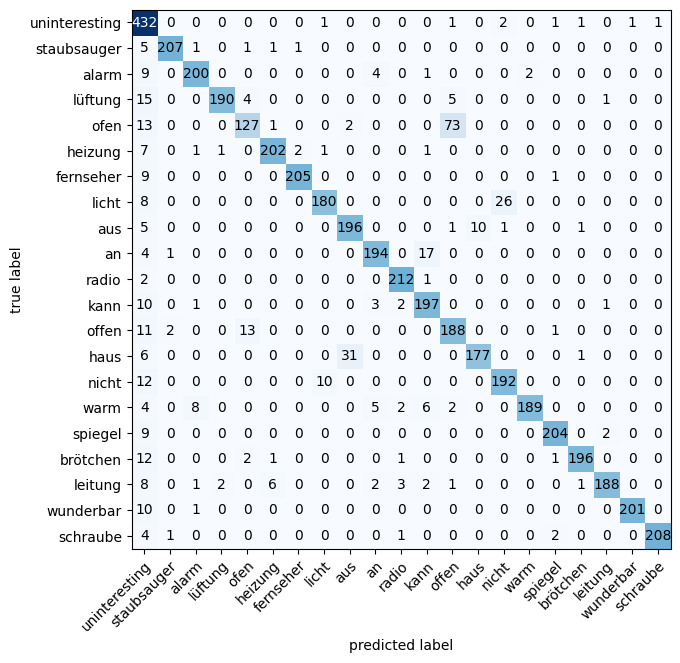

In [19]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes.CLASSES), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=classes.CLASSES, # turn the row and column labels into class names
    figsize=(10, 7)
);